## Cat/Dog Convolutional Neural Network Classifier

### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt
from keras_tuner import RandomSearch

plt.rcParams['figure.figsize'] = [8, 8] 

## Data setup

Creates dataset from folder of image files

In [2]:
data_dir = "./data/*/*"

In [3]:
files_list = tf.data.Dataset.list_files(data_dir, shuffle=False) 
num_img = len(files_list)
files_list = files_list.shuffle(num_img, reshuffle_each_iteration=False) 

### Useful Constants

In [4]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180
AUTOTUNE = tf.data.AUTOTUNE

class_names = ["cat", "dog"]

### Create training and validation sets
Specified 80% for training and 20% for validation

In [5]:
val_num = int(0.2 * num_img) # 20% for validation

train_set = files_list.skip(val_num) # makes training set skipping val_num # of data points
val_set = files_list.take(val_num) # makes validation set using val_num # of data points

print(f"Training Set Size: {tf.data.experimental.cardinality(train_set).numpy()} images")
print(f"Validation Set Size: {tf.data.experimental.cardinality(val_set).numpy()} images")


Training Set Size: 1120 images
Validation Set Size: 279 images


## Data Processing Helper Functions 

In [6]:
def get_label(filepath):
    """
    Determine image label from filepath and return it as a tensor.
    """
    filepath_split = tf.strings.split(filepath, os.path.sep)
    one_hot = filepath_split[-2] == class_names
    return tf.argmax(one_hot) # return tensor of binary label

#### Test `get_label` function to see output

In [7]:
for f in files_list.take(5):
    print(get_label(f)) 


tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)


In [8]:
def decode_img(img):
    """
    Decode JPEG encoded image to uint8 tensor and resize to desired size.
    """
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [9]:
def process_path(filepath):
    """
    Given an image filepath, extract the classname from the filename,
    load and decode the image into form for preprocessing, and return
    the decoded image and its corresponding label.
    """
    label = get_label(filepath)
    img = tf.io.read_file(filepath)
    img = decode_img(img)
    return img, label

#### Add parallel processing for speed

In [10]:
train_set = train_set.map(process_path, num_parallel_calls=AUTOTUNE)
val_set = val_set.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
def configure_for_performance(data):
    """
    Speeds up model performance by caching data and concurrently
    preprocessing data while training the model.
    """
    data = data.cache()
    data = data.shuffle(buffer_size=1000)
    data = data.batch(BATCH_SIZE)
    data = data.prefetch(buffer_size=AUTOTUNE)
    return data

#### Configure for performance - caching + prefetching

In [12]:
train_set = configure_for_performance(train_set)
val_set = configure_for_performance(val_set)

### Display some images

2023-04-27 20:43:55.311011: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-27 20:43:55.606212: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


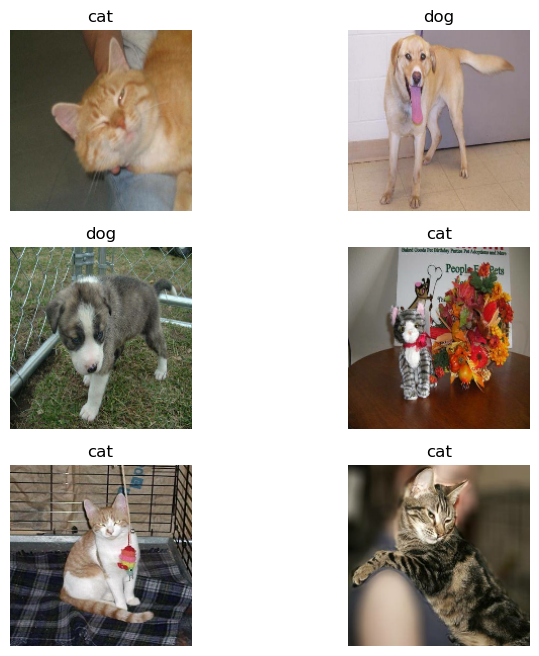

In [13]:
image_batch, label_batch = next(iter(train_set))

for i in range(6):
    ax = plt.subplot(3, 2, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

## Determine best hyperparameters
Commented out lists/numbers are other parameters tried and omitted to speed up search process

In [20]:
# num_filters_range =  [64] #[32, 64]  
# filter_size_range = [3] #[3, 5]
# pool_size_range = [3] #[2, 3]
dropout_rate_range = [0.3, 0.4] # [0.2, 0.5]
# dense_units_range  = [128] #[64, 128]
learning_rate_range = [1e-3, 1e-2] #1e-4,

In [22]:
def build_CNN_model(dropout_rate): #num_filters, filter_size, pool_size, dense_units, 
    """
    Constructs the CNN with layers and returns the model:
    - Rescale pixel values to be between 0-1 
    - 1st Convolution layer with ReLu activation function  
    - 1st Max Pooling Layer
    - 2nd Convolution layer with ReLu activation function 
    - 2nd Max Pooling Layer
    - 3rd Convolution layer with ReLu activation function  
    - 3rd Max Pooling Layer
    - Flatten layers
    - Dense Layer with ReLu activation function 
    - Dropout Layer
    - Final Dense Layer with 1 unit to predict the final label
    """
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    for i in [1, 2, 3]:
        model.add(tf.keras.layers.Conv2D(64*i,  (3,3), activation='relu')) 
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3))) 
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate)) 
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

In [23]:
def build_HP_model(hp):
    """
    Builds the model using chosen hyperparameters for tuning, returns model object.
    """
    model = build_CNN_model(
        #num_filters=hp.Choice('num_filters', num_filters_range),
        #filter_size=hp.Choice('filter_size', filter_size_range),
        #pool_size=hp.Choice('pool_size', pool_size_range),
        #dense_units = hp.Choice('units', dense_units_range),
        dropout_rate=hp.Float('dropout_rate', dropout_rate_range[0], dropout_rate_range[1]),
    )
    learning_rate = hp.Choice('learning_rate', learning_rate_range)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [24]:
tuner = kt.Hyperband(
    build_HP_model,
    objective='val_accuracy',
    max_epochs=20,
    seed=431,
    factor=3,
    directory='HP_Output',
    overwrite=True,
    project_name='CatDog_Hyperparameter_Tuning')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 59, 59, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 57, 57, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 19, 19, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 17, 192)      

### Search process for best hyperparameters

In [25]:
tuner.search(
    train_set,
    epochs=20,
    validation_data=val_set,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
)

Trial 30 Complete [00h 01m 21s]
val_accuracy: 0.6774193644523621

Best val_accuracy So Far: 0.7562723755836487
Total elapsed time: 00h 28m 11s
INFO:tensorflow:Oracle triggered exit


### Best Hyperparameters:

In [26]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hp.values)

{'dropout_rate': 0.317777977824741, 'learning_rate': 0.001, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0014'}


## Build model using best hyperparameters

In [28]:
model = build_CNN_model(
    #num_filters=best_hp.values["num_filters"], 
    #filter_size=best_hp.values["filter_size"], 
    #pool_size=best_hp.values["pool_size"], 
   # dense_units=best_hp.values["units"], 
    dropout_rate=best_hp.values["dropout_rate"]
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_hp.values["learning_rate"]),
    loss='binary_crossentropy',
    metrics=['accuracy'])

### Train the best model

In [29]:
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=10
)

Epoch 1/10
35/35 [==============================] - 13s 362ms/step - loss: 0.7018 - accuracy: 0.4991 - val_loss: 0.6927 - val_accuracy: 0.5054
Epoch 2/10
35/35 [==============================] - 12s 352ms/step - loss: 0.6902 - accuracy: 0.5411 - val_loss: 0.6938 - val_accuracy: 0.5018
Epoch 3/10
35/35 [==============================] - 12s 350ms/step - loss: 0.6866 - accuracy: 0.5527 - val_loss: 0.6786 - val_accuracy: 0.5771
Epoch 4/10
35/35 [==============================] - 14s 394ms/step - loss: 0.6533 - accuracy: 0.6054 - val_loss: 0.6694 - val_accuracy: 0.5842
Epoch 5/10
35/35 [==============================] - 17s 475ms/step - loss: 0.6344 - accuracy: 0.6580 - val_loss: 0.6188 - val_accuracy: 0.6523
Epoch 6/10
35/35 [==============================] - 15s 419ms/step - loss: 0.5791 - accuracy: 0.7009 - val_loss: 0.6409 - val_accuracy: 0.6308
Epoch 7/10
35/35 [==============================] - 13s 385ms/step - loss: 0.5340 - accuracy: 0.7366 - val_loss: 0.6438 - val_accuracy: 0.6380

### Plot of Accuracy and Validation Accuracy versus Epochs 

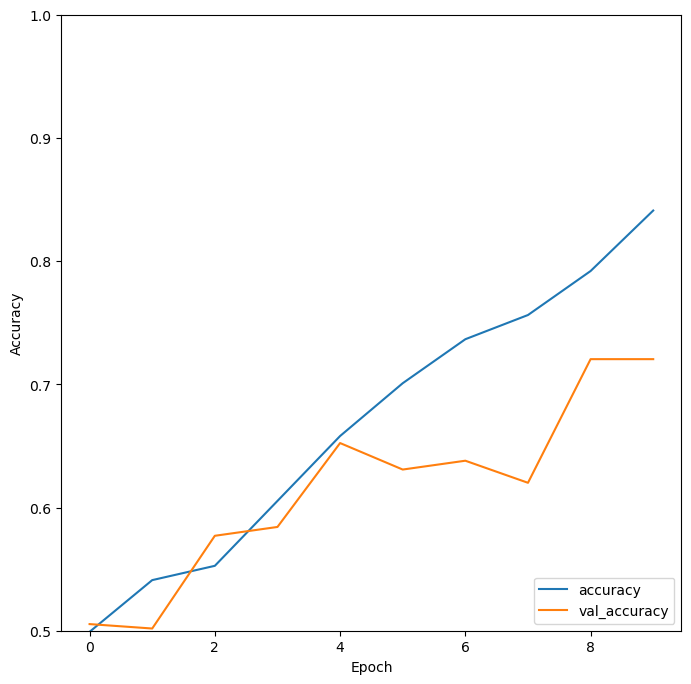

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
